_This notebook contains code and comments from Section 5.1 of the book [Ensemble Methods for Machine Learning](https://www.manning.com/books/ensemble-methods-for-machine-learning). Please see the book for additional details on this topic. This notebook and code are released under the [MIT license](https://github.com/gkunapuli/ensemble-methods-notebooks/blob/master/LICENSE)._

## 5.1	Gradient Descent for Minimization

When learning a machine learning model, we typically aim to find the model that fits the training data. The "goodness of this fit" is measured using the loss function. Model training is essentially finding the model parameters that minimize the loss function. Training of most machine learning algorithms can ultimately be cast into this framework, and attemtp to minimize the loss function in many different ways.

[Gradient descent](https://en.wikipedia.org/wiki/Gradient_descent) is one such way. It is an iterative technique that can be used to find the (local) minimimum of an objective function. It is an example of a first-order optimization technique as it uses first-derivative information, that is, the gradient.


---
### 5.1.1 Gradient Descent with an Illustrative Example
We will use the [Branin function](https://uqworld.org/t/branin-function/53) as a test function to visualize how gradient descent works. The Branin function is a function of two variables $w_1$ and $w_2$:

\\[
f(w_1, w_2) = a (w_2 - b w_1^2 + c w_1 - r)^2 + s (1-t) \cos{w_1} + s
\\]

Since we will be performing gradient descent, we will need the gradient of $f(w_1, w_2)$ with respect to both $w_1$ and $w_2$, which we collect into a two dimensional vector:

\\[
g(w_1, w_2) = \left[ \begin{array}{c} 
    \frac{\partial f(w_1, w_2)}{\partial w_1} \\ 
    \frac{\partial f(w_1, w_2)}{\partial w_2} 
    \end{array} \right] 
    = \left[ \begin{array}{c} 
    2a(w_2 - b w_1^2 + c w_1 - r) \cdot (-2 b w_1 + c) - s (1 - t) \sin{w_1} \\ 
    2a(w_2 - b w_1^2 + c w_1 - r) \end{array} \right]
\\]

In [1]:
import numpy as np

def branin(w, a, b, c, r, s, t):
    return a * (w[1] - b * w[0] ** 2 + c * w[0] - r) ** 2 + s * (1 - t) * np.cos(w[0]) + s


def branin_gradient(w, a, b, c, r, s, t):
    return np.array([2 * a * (w[1] - b * w[0] ** 2 + c * w[0] - r) * (-2 * b * w[0] + c) - s * (1 - t) * np.sin(w[0]),
                     2 * a * (w[1] - b * w[0] ** 2 + c * w[0] - r)])

We can visualize the function in three dimensions, as well as its contours in two dimensions.

In [2]:
import matplotlib.pyplot as plt

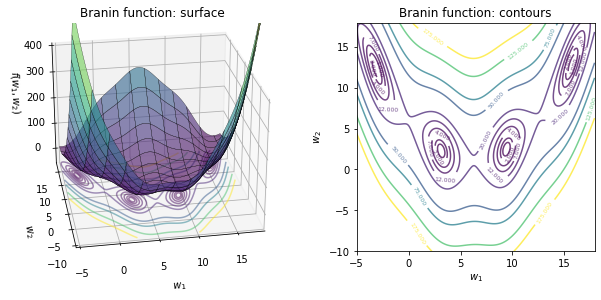

In [3]:
%matplotlib inline

# Set the constants of the Branin function
a, b, c, r, s, t = 1, 5.1 / (4 * np.pi ** 2), 5 / np.pi, 6, 10, 1 / (8 * np.pi)

# Set plotting boundaries and generate the mesh
w1Min, w1Max, w2Min, w2Max = -5, 18, -10, 18
w1, w2 = np.meshgrid(np.arange(w1Min, w1Max, 0.1),
                     np.arange(w2Min, w2Max, 0.1))

# Compute the Branin function over this mesh
z = np.apply_along_axis(branin, 1, np.c_[w1.ravel(), w2.ravel()], a, b, c, r, s, t)
z = z.reshape(w1.shape)

# Visualize the Branin function in 3d
fig = plt.figure(figsize=(9, 5))
ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_position([0.025, 0.15, 0.5, 0.9])
ax.plot_surface(w1, w2, z, rstride=20, cstride=20, alpha=0.6, linewidth=0.25, edgecolors='k', cmap='viridis')
ax.view_init(elev=25.0, azim=-100.0)
ax.contour(w1, w2, z, zdir='z', levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), 
           offset=-50, cmap='viridis', alpha=0.5)

ax.set_xlabel('$w_1$')
ax.set_xlim(w1Min, w1Max)
ax.set_ylabel('$w_2$')
ax.set_ylim(w2Min, w2Max)
ax.set_zlabel('$f(w_1, w_2)$')
ax.set_zlim(-50, 400)
ax.dist = 8
ax.set_title('Branin function: surface')

# Visualize the Branin function in 2d
ax = fig.add_subplot(1, 2, 2)
# ax.set_position([0.55, 0.11, 0.425, 0.85])
ctr = ax.contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), cmap='viridis', alpha=0.75)
ax.clabel(ctr, inline=1, fontsize=6)
ax.set_xlabel('$w_1$')
ax.set_ylabel('$w_2$')
ax.set_title('Branin function: contours')

fig.tight_layout()
pngFile = './figures/CH05_F02_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

This function has **four global minima**, which are the centers of the elliptical regions in contours. Gradient descent will aim to find one of these four global minima. 


Gradient descent performs the following steps:

Initialize: ``x_old`` = initial guess
while not converged:
    1. compute the negative gradient and normalize to unit length (direction)
    2. compute the step length using line search (distance)
    3. update the solution: x_new = x_old + distance * direction
    4. check for convergence: if amount of change between x_new and x_old is below our tolerance threshold
    
We can implement a basic version of gradient descent that can take a function $$f$$ and corresponding gradient $$g$$ as input and returns a locally optimal solution.

**Listing 5.1**: Gradient Descent    

In [4]:
from scipy.optimize import line_search

# Gradient descent with function f, and gradient g
def gradient_descent(f, g, x_init, max_iter=100, args=()):
    converged = False
    n_iter = 0

    x_old, x_new = np.array(x_init), None
    descent_path = np.full((max_iter + 1, 2), fill_value=np.nan)   # Save the descent path
    descent_path[n_iter] = x_old

    while not converged:
        n_iter += 1
        gradient = -g(x_old, *args)                                # Compute the negative gradient
        direction = gradient / np.linalg.norm(gradient)            # Normalize the gradient 
        step = line_search(f, g, x_old, direction, args=args)      # Compute the step length using line search

        if step[0] is None:                     # If step length doesn't return a useful value, make it 1.0
            distance = 1.0
        else:
            distance = step[0]

        x_new = x_old + distance * direction                    # Compute the update
        descent_path[n_iter] = x_new

        # Update status
        # print('Iter {0:02d}: obj value = {1} (step={2}, dir={3}'.format(n_iter, step[3], step[0], direction))

        err = np.linalg.norm(x_new - x_old)                        # Compute amount of change between x_new and x_old
        if err <= 1e-3 or n_iter >= max_iter:                      # Check for convergence
            converged = True

        x_old = x_new                                              # Get ready for the next iteration

    return x_new, descent_path

We perform gradient descent on the Branin function, intializing our solution at $w = [-4, -5]$, and visualize our solution path.

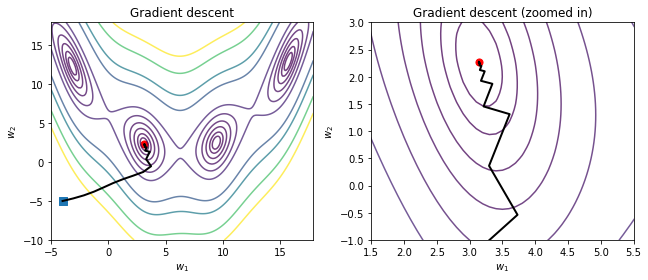

In [5]:
%matplotlib inline

# Set the constants of the Branin function
a, b, c, r, s, t = 1, 5.1 / (4 * np.pi ** 2), 5 / np.pi, 6, 10, 1 / (8 * np.pi)

# Initialize and perform gradient descent
w_init = np.array([-4, -5])
w_optimal, w_path = gradient_descent(branin, branin_gradient, w_init, args=(a, b, c, r, s, t))

# Plot optimization path over all iterations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), cmap='viridis', alpha=0.75)
ax[0].plot(w_path[:, 0], w_path[:, 1], 'k', linewidth=2)
ax[0].scatter(w_init[0], w_init[1], s=50, marker='s')  
ax[0].scatter(w_optimal[0], w_optimal[1], s=50, c='r')  
ax[0].set_xlabel('$w_1$')
ax[0].set_ylabel('$w_2$')
ax[0].set_title('Gradient descent')

# Plot optimization path zoomed in
ax[1].contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), cmap='viridis', alpha=0.75)
ax[1].plot(w_path[:, 0], w_path[:, 1], 'k', linewidth=2)
ax[1].scatter(w_optimal[0], w_optimal[1], s=50, c='r')  
ax[1].set_xlim(1.5, 5.5)
ax[1].set_ylim(-1, 3)
ax[1].set_xlabel('$w_1$')
ax[1].set_ylabel('$w_2$')
ax[1].set_title('Gradient descent (zoomed in)')

fig.tight_layout()
pngFile = './figures/CH05_F03_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

Two important things to note here:
1. **Gradient descent typically demonstrates zig-zagging behavior**, especially in narrow valleys. This is a consequence of rapidly changing gradient direction. The magnitude of the gradient also becomes smaller as we approach the minima.

2. Of the four minima, which one will gradient descent converge to? That depends on the initial guess. As we see below, **different initializations will cause gradient descent to reach different minima**.

c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
c:\users\gauta\appdata\local\programs\python\python36\lib\site-packages\scipy\optimize\linesearch.py:314: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


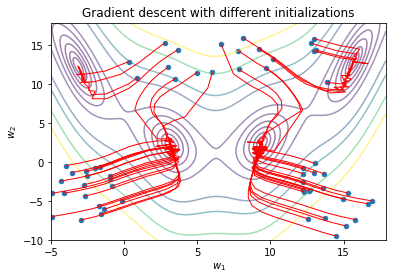

In [6]:
%matplotlib inline

n = 20
inits = np.r_[np.c_[np.random.uniform(0, 15, n), np.random.uniform(10, 16, n)],
              np.c_[np.random.uniform(-5, 0, n), np.random.uniform(-10, 0, n)],
              np.c_[np.random.uniform(12, 17, n), np.random.uniform(-10, 0, n)]]


plt.figure()
plt.contour(w1, w2, z, levels=np.array([1, 2, 4, 7, 12, 20, 50, 75, 125, 175]), cmap='viridis', alpha=0.5)

# For each initialization, optimize and plot the path
for i, w_init in enumerate(inits):
    w, path = gradient_descent(branin, branin_gradient, w_init, args=(a, b, c, r, s, t))
    plt.plot(path[:, 0], path[:, 1], 'r', linewidth=1)

plt.scatter(inits[:, 0], inits[:, 1], s=20)    
plt.xlabel('$w_1$')
plt.ylabel('$w_2$')
plt.title('Gradient descent with different initializations');

fig.tight_layout()
pngFile = './figures/CH05_F04_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight', pad_inches=0)

---
### 5.1.2	Gradient Descent over Loss Functions for Training

Let's consider a simple classification problem in a two-dimensional feature space

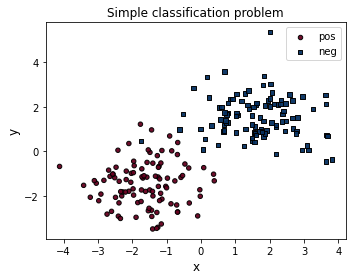

In [7]:
%matplotlib inline

from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=200, n_features=2, 
                  centers=[[-1.5, -1.5], [1.5, 1.5]], random_state=42)

from visualization import plot_2d_data
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 4))
plot_2d_data(ax, X, y, xlabel='x', ylabel='y', 
             title='Simple classification problem', 
             legend=['pos', 'neg'], colormap='RdBu')
fig.tight_layout()
pngFile = './figures/CH05_F05_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight')

Now, let's say that we want to learn a linear classifier $h(\mathbf{x})$ of the form shown below:

\\[
h_\mathbf{w}(\mathbf{x}) = w_1 x_1 + w_2 x_2,
\\]

which takes a training example $\mathbf{x} = [x_1, x_2]^T$. The classifier is parameterized by $\mathbf{w} = [w_1, w_2]^T$, which we have to learn using the training examples. In order to train a classifier, we'll need a loss function. 

For this problem, we will chose the **squared loss** of the classifier $h_\mathbf{w}(\mathbf{x})$ over the training set of $n$ training examples $\mathbf{x}_i = [x_1^i, x_2^i]^T$, $i=1, ..., n$, with corresponding labels $y_i$.

\\[
f_{loss}(w_1, w_2) = \frac{1}{2} \sum_{i=1}^n \left( y_i - h_\mathbf{w}(\mathbf{x}_i) \right)^2 = \frac{1}{2} \sum_{i=1}^n \left( y_i - w_1 x_1^i - w_2 x_2^i \right)^2 = \frac{1}{2} (\mathbf{y} - X\mathbf{w})^T (\mathbf{y} - X\mathbf{w}).
\\]

Similar to the Branin function in Section 5.2.1, we can compute the gradient of this loss function with respect to $w_1$ and $w_2$.

\\[
g(w_1, w_2) = \left[ \begin{array}{c} 
    \frac{\partial f_{loss}(w_1, w_2)}{\partial w_1} \\ 
    \frac{\partial f_{loss}(w_1, w_2)}{\partial w_2} 
    \end{array} \right] 
    = \left[ \begin{array}{c} 
    - \sum_{i=1}^n \left( y_i - w_1 x_1 - w_2 x_2 \right) x_1\\ 
    - \sum_{i=1}^n \left( y_i - w_1 x_1 - w_2 x_2 \right) x_2 \end{array} \right]
    = -X^T (\mathbf{y} - X\mathbf{w})
\\]

In both the equations above, the expressions on the far right are the vectorized versions of the loss function, where $X$ is the data matrix and $\mathbf{y}$ is the label vector. The vectorized version is more compact and easier and more efficient to implement as it avoids explicit loops for summation. 

In [8]:
def squared_loss(w, X, y):
    return 0.5 * np.sum((y - np.dot(X, w))**2)


def squared_loss_gradient(w, X, y):
    return -np.dot(X.T, (y - np.dot(X, w)))

As before, we visualize the function we want to optimize.

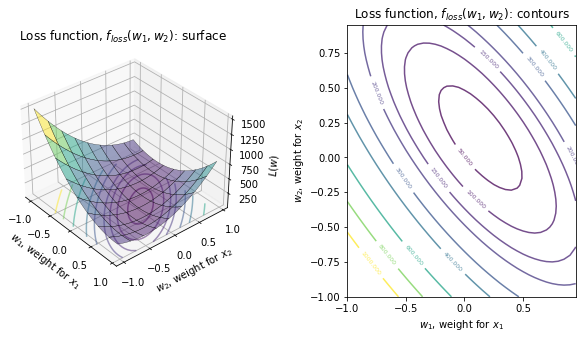

In [9]:
%matplotlib inline

fig = plt.figure(figsize=(9, 5))

# Plot the loss function
w1Min, w1Max, w2Min, w2Max = -1, 1, -1, 1
w1, w2 = np.meshgrid(np.arange(w1Min, w1Max, 0.05),
                     np.arange(w2Min, w2Max, 0.05))
z = np.apply_along_axis(squared_loss, 1, np.c_[w1.ravel(), w2.ravel()], X, y)
z = z.reshape(w1.shape)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.plot_surface(w1, w2, z, rstride=5, cstride=5, alpha=0.5, linewidth=0.25, edgecolors='k', cmap='viridis')
ax.view_init(elev=34, azim=-40.0)
ax.contour(w1, w2, z, zdir='z', levels=np.array([50, 100, 150, 200, 300, 400, 600, 800, 1000]),
           offset=-50, cmap='viridis', alpha=0.5)
ax.set_xlabel('$w_1$, weight for $x_1$')
ax.set_ylabel('$w_2$, weight for $x_2$')
ax.set_zlabel('$L(w)$ ')
ax.set_title('Loss function, $f_{loss}(w_1, w_2)$: surface')
# pos1 = ax.get_position() # get the original position 
# pos2 = [pos1.x0 - 0.1, pos1.y0,  pos1.width, pos1.height] 
# ax.set_position(pos2) # set a new position

# Plot the contour
ax = fig.add_subplot(1, 2, 2)
ctr = ax.contour(w1, w2, z, levels=np.array([50, 100, 150, 200, 300, 400, 600, 800, 1000]),
                 cmap='viridis', alpha=0.75)
ax.clabel(ctr, inline=1, fontsize=6)
ax.set_xlabel('$w_1$, weight for $x_1$')
ax.set_ylabel('$w_2$, weight for $x_2$')
ax.set_title('Loss function, $f_{loss}(w_1, w_2)$: contours')
pos1 = ax.get_position() # get the original position 
pos2 = [pos1.x0 + 0.1, pos1.y0, pos1.width, pos1.height] 
ax.set_position(pos2) # set a new position


# fig.tight_layout()
pngFile = './figures/CH05_F06_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight')

As before, we perform gradient descent, this time initializing at $\mathbf{w} = [0.0, -0.99]$.

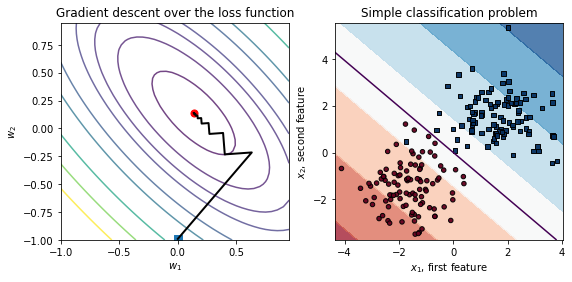

In [10]:
%matplotlib inline

w_init = np.array([0.0, -0.99])
w, path = gradient_descent(squared_loss, squared_loss_gradient, w_init, args=(X, y))

# Compute the Loss function in this domain
w1Min, w1Max, w2Min, w2Max = -1, 1, -1, 1
w1, w2 = np.meshgrid(np.arange(w1Min, w1Max, 0.05),
                     np.arange(w2Min, w2Max, 0.05))
z = np.apply_along_axis(squared_loss, 1, np.c_[w1.ravel(), w2.ravel()], X, y)
z = z.reshape(w1.shape)

# Plot optimization path over all iterations
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(9, 4))
ax[0].contour(w1, w2, z, levels=np.array([25, 50, 100, 150, 200, 300, 400, 600, 800, 1000]),
              cmap='viridis', alpha=0.75)
ax[0].scatter(w_init[0], w_init[1], s=50, marker='s')
ax[0].scatter(w[0], w[1], c='r', s=50)
ax[0].plot(path[:, 0], path[:, 1], 'k', linewidth=2)
ax[0].set_xlabel('$w_1$')
ax[0].set_ylabel('$w_2$')
ax[0].set_title('Gradient descent over the loss function')

# Plot the solution
xMin, xMax = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
yMin, yMax = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
xMesh, yMesh = np.meshgrid(np.arange(xMin, xMax, 0.05),
                           np.arange(yMin, yMax, 0.05))
zMesh = np.dot(np.c_[xMesh.ravel(), yMesh.ravel()], w)
zMesh = (zMesh.reshape(xMesh.shape) + 1) / 2
ax[1].contourf(xMesh, yMesh, zMesh, cmap='RdBu', alpha=0.75)
ax[1].contour(xMesh, yMesh, zMesh, levels=[0.5])
plot_2d_data(ax[1], X, y, colormap='RdBu')
ax[1].set_xlabel('$x_1$, first feature')
ax[1].set_ylabel('$x_2$, second feature')
ax[1].set_title('Simple classification problem');

# fig.tight_layout()
pngFile = './figures/CH05_F07_Kunapuli.png'
plt.savefig(pngFile, dpi=300, bbox_inches='tight')

In [11]:
print(w)

[0.13643511 0.13862275]


The final $\mathbf{w}$ is trained by performing gradient descent on the loss function defined over the training examples. From the figure on the right above, we can see that gradient descent does, in fact, produce a nice fit.

In [12]:
ypred = (np.dot(X, w) >= 0).astype(int)
from sklearn.metrics import accuracy_score
accuracy_score(y, ypred)

0.995